In [ ]:
#Install necessary packages
# !sudo apt-get update
# !apt-get install tesseract-ocr -y
# !pip install pytesseract pyspellchecker edge-tts opencv-python-headless joblib matplotlib scipy --quiet

import os
import cv2
import random
import shutil
import pickle
import asyncio
import edge_tts
import numpy as np
import pytesseract
import nest_asyncio
from sklearn.svm import SVC
from google.colab import drive
from google.colab import files
from skimage.feature import hog
import matplotlib.pyplot as plt
from IPython.display import Audio
from spellchecker import SpellChecker
from scipy.ndimage import generic_filter
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

nest_asyncio.apply()

drive.mount('/content/drive')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,631 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,563 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages 

In [3]:
# File paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/Text to Speech Project/Datasets/ocr-dataset"
model_path = "/content/drive/My Drive/Colab Notebooks/Text to Speech Project/best_ocr_model.pkl"
test_image_path = "/content/drive/My Drive/Colab Notebooks/Text to Speech Project/test2.png"

In [4]:
#Text to speesh

# Voice options
VOICES = ['en-AU-NatashaNeural', 'en-AU-WilliamNeural', 'en-CA-ClaraNeural', 'en-CA-LiamNeural', 'en-GB-LibbyNeural', 'en-GB-MaisieNeural', 'ar-SA-HamedNeural']
TEXT = "Hello!"
VOICE = VOICES[4]
OUTPUT_FILE = os.path.join("/content/drive/My Drive/Colab Notebooks/Text to Speech Project/Saved output", "text.mp3")

def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = ' '.join([spell.correction(word) if spell.correction(word) else word for word in text.split()])
    print("Corrected Text:")
    print(corrected_text)
    return corrected_text

async def amain() -> None:
    #corrected_text = correct_spelling(TEXT)
    #communicate = edge_tts.Communicate(corrected_text, VOICE)
    communicate = edge_tts.Communicate(TEXT, VOICE)
    await communicate.save(OUTPUT_FILE)

#asyncio.run(amain())
#Audio(OUTPUT_FILE, autoplay=True)

Saving test2.jpg to test2 (3).jpg
Segmenting lines...
Lines detected: 3
Segmenting words...
Words detected: 10
Segmenting characters...
Characters detected: 39
Showing results...


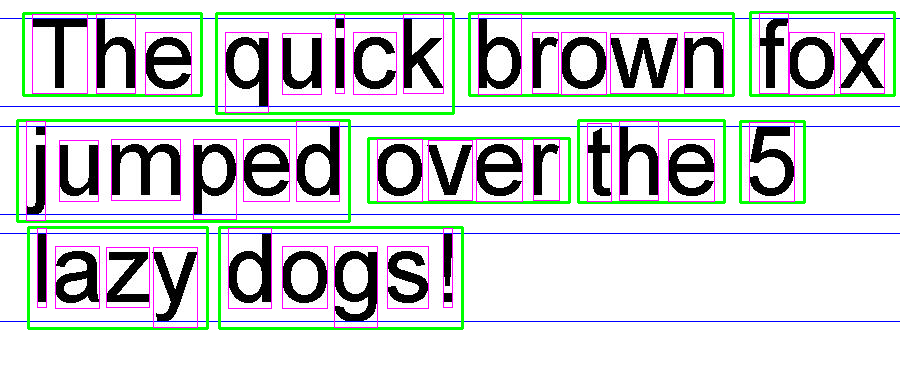

In [ ]:
def upload_img():
    from google.colab import files
    uploaded = files.upload()
    for file_name in uploaded.keys():
        return file_name

def noise_removal(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    img = cv2.medianBlur(img, 3)
    return img


def preprocess_img(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh_img = cv2.threshold(gray_img, 210, 230, cv2.THRESH_BINARY_INV)

    no_noise_img = noise_removal(thresh_img)

    return no_noise_img

def segment_lines(binary_img, output_img):
    horizontal_sum = np.sum(binary_img, axis=1)
    line_indices = np.where(horizontal_sum > 0)[0]

    lines = []
    current_line = [line_indices[0]]
    for i in range(1, len(line_indices)):
        if line_indices[i] - line_indices[i - 1] > 5:
            lines.append(current_line)
            current_line = []
        current_line.append(line_indices[i])
    lines.append(current_line)

    for line in lines:
        top, bottom = min(line), max(line)
        cv2.line(output_img, (0, top), (output_img.shape[1], top), (255, 0, 0), 1)
        cv2.line(output_img, (0, bottom), (output_img.shape[1], bottom), (255, 0, 0), 1)

    print(f"Lines detected: {len(lines)}")
    return lines

def segment_words(binary_img, output_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 13))  # Reduced width to avoid over-merging
    dilated_img = cv2.dilate(binary_img, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:  # Filter small noise
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            words.append((x, y, w, h))

    print(f"Words detected: {len(words)}")
    return words

def segment_characters(binary_img, output_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))
    dilated_img = cv2.dilate(binary_img, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 5 and h > 10:  # Filter small noise
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 255), 1)
            characters.append((x, y, w, h))

    print(f"Characters detected: {len(characters)}")
    return characters


img_path = upload_img()
if not img_path:
    print("No image uploaded!")
else:
    original_img = cv2.imread(img_path)
    binary_img = preprocess_img(original_img)

    output_img = original_img.copy()  # Keep original colors for output

    print("Segmenting lines...")
    segment_lines(binary_img, output_img)

    print("Segmenting words...")
    segment_words(binary_img, output_img)

    print("Segmenting characters...")
    segment_characters(binary_img, output_img)

    print("Showing results...")
    cv2_imshow(output_img)

Saving test.png to test (1).png
Displaying image with bounding boxes:


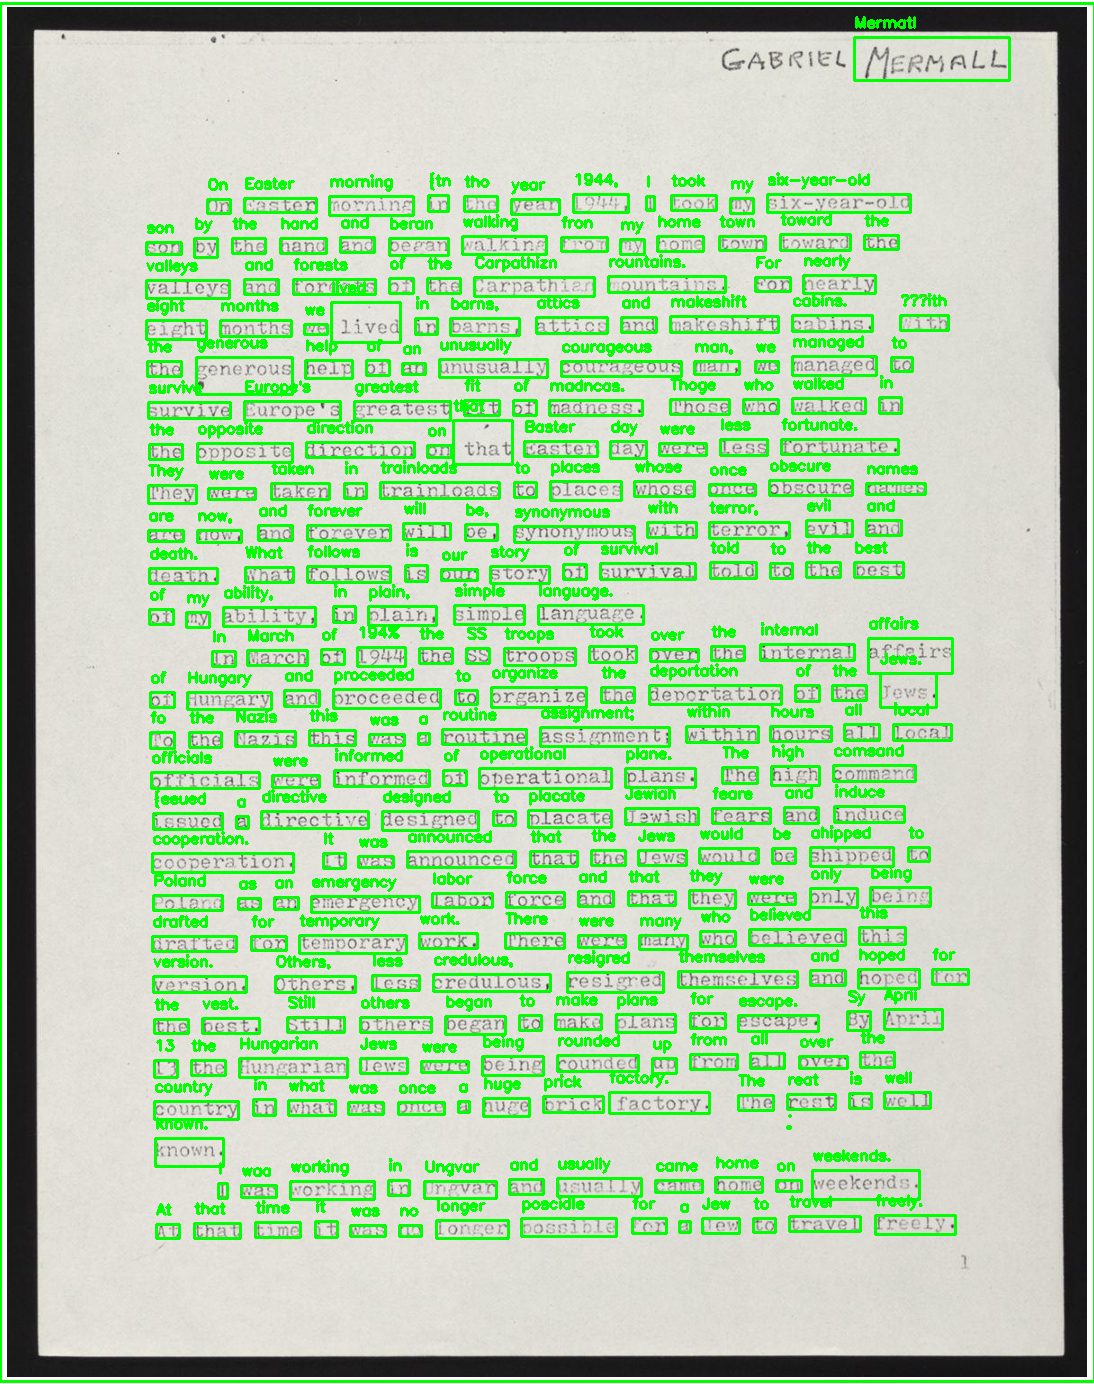

Extracted Text: “Gapaiel Mermatl

On Easter morning {tn tho year 1944, I took my six-year-old
son by the hand and beran walking fron my home town toward the
valleys and forests of the Carpathizn rountains. For nearly
eight months we lived in barns, attics and makeshift cabins. ‘ith
the generous help of an unusually courageous man, we managed to
survive Europe's greatest fit of madncas. Thoge who walked in
the opposite direction on that Baster day were less fortunate.
They were taken in trainloads to places whose once obscure names
are now, and forever will be, synonymous with terror, evil and
death. What follows is our story of survival told to the best
of my ability, in plain, simple language.

In March of 194% the SS troops took over the internal affairs
of Hungary and proceeded to organize the deportation of the Jews.
fo the Nazis this was a routine assignment; within hours all iocal
officials were informed of operational plane. The high comsand
{eeued a directive designed to placat

In [8]:
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

def upload_img():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        return file_name

def noise_removal(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    img = cv2.medianBlur(img, 3)
    return img


def preprocess_img(img):

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh_img = cv2.threshold(gray_img, 210, 230, cv2.THRESH_BINARY)

    no_noise_img = noise_removal(thresh_img)

    return no_noise_img

def perform_ocr_with_bounding_boxes(img_path):
    img = cv2.imread(img_path)

    preprocessed_img = preprocess_img(img)

    data = pytesseract.image_to_data(preprocessed_img, output_type=pytesseract.Output.DICT)

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:  # Confidence threshold
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            text = data['text'][i]

            # Draw a rectangle and label it with the word
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            img = cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    print("Displaying image with bounding boxes:")
    cv2_imshow(img)

    return pytesseract.image_to_string(preprocessed_img)


img_path = upload_img()
if(img_path):
    extracted_text = perform_ocr_with_bounding_boxes(img_path)

    print("Extracted Text:", extracted_text)


async def amain() -> None:
    corrected_text = correct_spelling(extracted_text)
    communicate = edge_tts.Communicate(corrected_text, VOICE)
    await communicate.save(OUTPUT_FILE)

asyncio.run(amain())
Audio(OUTPUT_FILE, autoplay=True)


Loading saved model...
Upload an image for recognition:


Saving test2.jpg to test2 (1).jpg


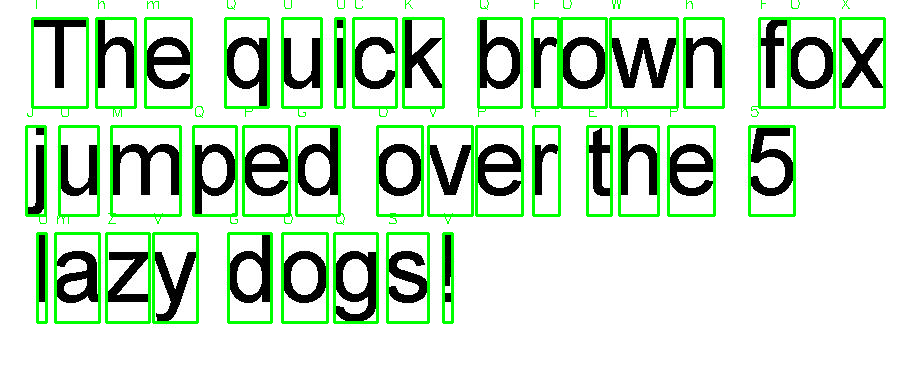

Recognized Text: Thm QUUCK QFOWh FOX
JUMQPG OVPF EhP 5
UmZV GOQSV
Corrected Text:
the quick fowl FOX jump of eh 5 um goes


In [7]:
def load_character_dataset():
    characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!',.?"
    data = []
    labels = []

    fonts = [
        cv2.FONT_HERSHEY_SIMPLEX,
        cv2.FONT_HERSHEY_COMPLEX,
        cv2.FONT_HERSHEY_DUPLEX,
        cv2.FONT_HERSHEY_TRIPLEX,
        cv2.FONT_HERSHEY_PLAIN,
        cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
        cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
        cv2.FONT_HERSHEY_COMPLEX_SMALL,
        cv2.FONT_ITALIC,
    ]

    for char in characters:
        for font in fonts:
            for _ in range(40):
                img = np.zeros((100, 100), dtype=np.uint8)
                font_scale = np.random.uniform(1.5, 2.5)
                thickness = np.random.randint(1, 3)
                text_size = cv2.getTextSize(char, font, font_scale, thickness)[0]
                x = (img.shape[1] - text_size[0]) // 2
                y = (img.shape[0] + text_size[1]) // 2
                cv2.putText(img, char, (x, y), font, font_scale, (255), thickness, cv2.LINE_AA)
                cropped = cv2.resize(img, (40, 40), interpolation=cv2.INTER_AREA)

                hog_features = hog(cropped, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=12, block_norm='L2-Hys')

                horizontal_projection = np.sum(cropped, axis=1)
                vertical_projection = np.sum(cropped, axis=0)
                intersections = []
                for i, h_val in enumerate(horizontal_projection):
                    if h_val > 0:
                        for j, v_val in enumerate(vertical_projection):
                            if v_val > 0 and cropped[i, j] > 0:
                                intersections.append((j / cropped.shape[1], i / cropped.shape[0]))
                intersection_count = len(intersections)
                intersection_features = np.array(intersections).flatten()
                if len(intersection_features) < 100:
                    intersection_features = np.pad(intersection_features, (0, 100 - len(intersection_features)), 'constant')
                else:
                    intersection_features = intersection_features[:100]

                pixel_count = np.sum(cropped > 0)
                stroke_thickness = np.max(horizontal_projection)
                bounding_box_height = np.count_nonzero(horizontal_projection)
                bounding_box_width = np.count_nonzero(vertical_projection)
                aspect_ratio = bounding_box_width / (bounding_box_height + 1e-5)
                symmetry = np.sum(cropped == np.flip(cropped, axis=1)) / cropped.size

                moments = cv2.moments(cropped)
                hu_moments = cv2.HuMoments(moments).flatten()

                edge_density = np.sum(cv2.Canny(cropped, 100, 200) > 0) / cropped.size

                corners = cv2.goodFeaturesToTrack(cropped, maxCorners=25, qualityLevel=0.02, minDistance=1)
                corners_count = 0 if corners is None else len(corners)
                histogram, _ = np.histogram(cropped, bins=16, range=(0, 256))

                pixel_mean = np.mean(cropped)
                pixel_std = np.std(cropped)

                features = np.concatenate([hog_features, intersection_features, [pixel_count, intersection_count, stroke_thickness, bounding_box_height, bounding_box_width, aspect_ratio, symmetry, edge_density, corners_count, pixel_mean, pixel_std], hu_moments, histogram])
                data.append(features)
                labels.append(char)

    return np.array(data), np.array(labels)

def preprocess_character_with_features(char_img):
    padded_img = cv2.copyMakeBorder(char_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
    resized_char = cv2.resize(padded_img, (40, 40), interpolation=cv2.INTER_AREA)

    hog_features = hog(resized_char, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=12, block_norm='L2-Hys')

    horizontal_projection = np.sum(resized_char, axis=1)
    vertical_projection = np.sum(resized_char, axis=0)
    intersections = []
    for i, h_val in enumerate(horizontal_projection):
        if h_val > 0:
            for j, v_val in enumerate(vertical_projection):
                if v_val > 0 and resized_char[i, j] > 0:
                    intersections.append((j / resized_char.shape[1], i / resized_char.shape[0]))
    intersection_count = len(intersections)
    intersection_features = np.array(intersections).flatten()
    if len(intersection_features) < 100:
        intersection_features = np.pad(intersection_features, (0, 100 - len(intersection_features)), 'constant')
    else:
        intersection_features = intersection_features[:100]


    pixel_count = np.sum(resized_char > 0)
    stroke_thickness = np.max(horizontal_projection)
    bounding_box_height = np.count_nonzero(horizontal_projection)
    bounding_box_width = np.count_nonzero(vertical_projection)
    aspect_ratio = bounding_box_width / (bounding_box_height + 1e-5)
    symmetry = np.sum(resized_char == np.flip(resized_char, axis=1)) / resized_char.size

    moments = cv2.moments(resized_char)
    hu_moments = cv2.HuMoments(moments).flatten()

    edge_density = np.sum(cv2.Canny(resized_char, 100, 200) > 0) / resized_char.size

    corners = cv2.goodFeaturesToTrack(resized_char, maxCorners=25, qualityLevel=0.02, minDistance=1)
    corners_count = 0 if corners is None else len(corners)
    histogram, _ = np.histogram(resized_char, bins=16, range=(0, 256))

    pixel_mean = np.mean(resized_char)
    pixel_std = np.std(resized_char)

    return np.concatenate([hog_features, intersection_features, [pixel_count, intersection_count, stroke_thickness, bounding_box_height, bounding_box_width, aspect_ratio, symmetry, edge_density, corners_count, pixel_mean, pixel_std], hu_moments, histogram])

def train_and_evaluate_model(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(random_state=42, n_estimators=400, max_depth=60)
    rf_model.fit(X_train, y_train)
    train_accuracy = rf_model.score(X_train, y_train)
    test_accuracy = rf_model.score(X_test, y_test)

    print(f"Random Forest Training Accuracy: {train_accuracy}")
    print(f"Random Forest Testing Accuracy: {test_accuracy}")

    return rf_model

def noise_removal(img):
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    img = cv2.medianBlur(img, 3)
    return img

def preprocess_img(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh_img = cv2.threshold(gray_img, 210, 230, cv2.THRESH_BINARY_INV)
    no_noise_img = noise_removal(thresh_img)
    return no_noise_img

def segment_lines_and_characters_projection(img, original_img, model):
    horizontal_sum = np.sum(img, axis=1)
    line_boundaries = []
    in_line = False
    start = 0

    for i, val in enumerate(horizontal_sum):
        if val > 0 and not in_line:
            start = i
            in_line = True
        elif val == 0 and in_line:
            line_boundaries.append((start, i))
            in_line = False

    recognized_text = ""
    for start, end in line_boundaries:
        line_img = img[start:end, :]
        vertical_sum = np.sum(line_img, axis=0)
        char_boundaries = []
        in_char = False
        start_x = 0

        for j, val in enumerate(vertical_sum):
            if val > 0 and not in_char:
                start_x = j
                in_char = True
            elif val == 0 and in_char:
                char_boundaries.append((start_x, j))
                in_char = False

        for idx, (start_x, end_x) in enumerate(char_boundaries):
            char_img = line_img[:, start_x:end_x]
            padded_char = cv2.copyMakeBorder(char_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)
            resized_char = cv2.resize(padded_char, (40, 40), interpolation=cv2.INTER_AREA)
            features = preprocess_character_with_features(resized_char)

            if resized_char.shape == (40, 40):
                char_label = model.predict([features])[0]
            else:
                char_label = " "

            cv2.rectangle(original_img, (start_x, start), (end_x, end), (0, 255, 0), 2)
            cv2.putText(original_img, char_label, (start_x, start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            recognized_text += char_label

            if idx + 1 < len(char_boundaries) and char_boundaries[idx + 1][0] - end_x > 15:
                recognized_text += " "

        recognized_text += "\n"

    cv2_imshow(original_img)
    return recognized_text.strip()



if os.path.exists(model_path):
    print("Loading saved model...")
    with open(model_path, "rb") as model_file:
        best_model = pickle.load(model_file)
else:
    print("Generating dataset with variations...")
    data, labels = load_character_dataset()
    print("Training and evaluating model...")
    best_model = train_and_evaluate_model(data, labels)
    print("Saving the model...")
    with open(model_path, "wb") as model_file:
        pickle.dump(best_model, model_file)

print("Upload an image for recognition:")
uploaded = files.upload()

for filename in uploaded.keys():
    uploaded_img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    binary_img = preprocess_img(uploaded_img)
    raw_text = segment_lines_and_characters_projection(binary_img, uploaded_img, best_model)
    print("Recognized Text:", raw_text)


async def amain():
    corrected_text = correct_spelling(raw_text)
    communicate = edge_tts.Communicate(corrected_text, VOICE)
    await communicate.save(OUTPUT_FILE)

asyncio.run(amain())
Audio(OUTPUT_FILE, autoplay=True)
